In [342]:
%matplotlib inline

import sys
PATH = '/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2'
sys.path.insert(0, PATH) 
from fma_metadata import utils

# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

import random
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler

# Regression Libraries
import statsmodels.api as sm
from termcolor import colored as cl
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error




import warnings
warnings.filterwarnings('ignore')

### Data preprocessing

In [343]:
echonest = utils.load("/Users/gaetanoantonicchio/Desktop/dataset_DM2/fma_metadata/echonest.csv")
tracks = utils.load("/Users/gaetanoantonicchio/Desktop/dataset_DM2/fma_metadata/tracks.csv")

In [344]:
echo_genres = echonest['echonest','audio_features'].merge(tracks['track'][['genre_top']],on='track_id')
echo_genres.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
track_id,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Pop
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop


In [345]:
echo_genres['genre_top'].value_counts()

Rock                   3892
Electronic             2170
Hip-Hop                 910
Folk                    874
Old-Time / Historic     357
Pop                     346
Classical               265
Jazz                    241
International           133
Instrumental             84
Blues                    66
Experimental             17
Country                   0
Easy Listening            0
Soul-RnB                  0
Spoken                    0
Name: genre_top, dtype: int64

### Remove outliers
Execute Isolation forest on all echonest dataset

In [346]:
def echo_outliers_detector(gen): 
    echo = echo_genres[echo_genres['genre_top'].isin([gen])]
    genre = echo['genre_top']
    echo.drop('genre_top',axis=1,inplace=True)
    
    # transform data in an np.ndarray 
    X = np.array(echo)
    
    #isolation-forest sklearn version
    F0 = IsolationForest(random_state=42, n_estimators=300, contamination=0.02).fit(X) 
    
    # score isolation forest - sklearn
    outliers_sk = F0.predict(X)
    
    # IsolationForest Sklearn
    echo['outlier_IF_sklearn'] = outliers_sk
    echo['outlier_IF_sklearn'] = echo['outlier_IF_sklearn'].apply(lambda x: 'inlier' if x==1 else 'outlier')
    
    # sklearn IF
    print(f"**** Anomaly detected for {gen}  *****'")
    print(echo['outlier_IF_sklearn'].value_counts())
    print()
    
    echo = echo[echo['outlier_IF_sklearn'] == 'inlier']
    echo.drop('outlier_IF_sklearn',axis=1,inplace=True)
    return echo

In [347]:
# Echonest genres anomaly free (without outlier_IF_sklearn and genre_top column)
echo_rock=echo_outliers_detector('Rock')
echo_electro=echo_outliers_detector('Electronic')
echo_hh=echo_outliers_detector('Hip-Hop')
echo_folk=echo_outliers_detector('Folk')
echo_old=echo_outliers_detector('Old-Time / Historic')
echo_pop=echo_outliers_detector('Pop')
echo_classic=echo_outliers_detector('Classical')
echo_jazz=echo_outliers_detector('Jazz')

**** Anomaly detected for Rock  *****'
inlier     3814
outlier      78
Name: outlier_IF_sklearn, dtype: int64

**** Anomaly detected for Electronic  *****'
inlier     2126
outlier      44
Name: outlier_IF_sklearn, dtype: int64

**** Anomaly detected for Hip-Hop  *****'
inlier     891
outlier     19
Name: outlier_IF_sklearn, dtype: int64

**** Anomaly detected for Folk  *****'
inlier     856
outlier     18
Name: outlier_IF_sklearn, dtype: int64

**** Anomaly detected for Old-Time / Historic  *****'
inlier     349
outlier      8
Name: outlier_IF_sklearn, dtype: int64

**** Anomaly detected for Pop  *****'
inlier     339
outlier      7
Name: outlier_IF_sklearn, dtype: int64

**** Anomaly detected for Classical  *****'
inlier     259
outlier      6
Name: outlier_IF_sklearn, dtype: int64

**** Anomaly detected for Jazz  *****'
inlier     236
outlier      5
Name: outlier_IF_sklearn, dtype: int64



## Linear Relationships


### Historical

Text(0.5, 1, 'Correlation Matrix Echonest Old-Time/Historical')

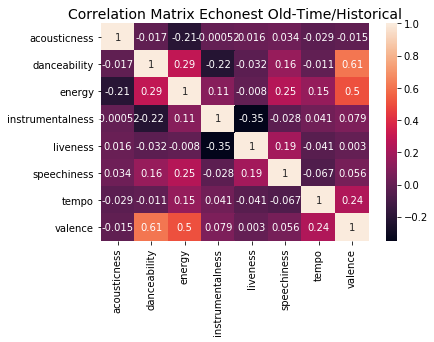

In [348]:
#Check Old-Time / Historic correlation
sns.heatmap(echo_old.corr(),annot=True)
plt.title("Correlation Matrix Echonest Old-Time/Historical", fontsize=14)

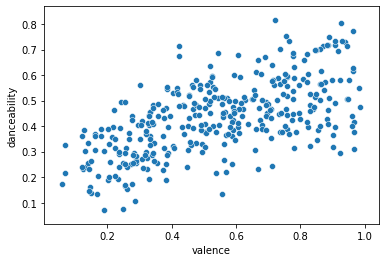

In [349]:
# Best correlation with dependent variable valence and danceability with genre selected
sns.scatterplot(data=echo_old, y='danceability', x="valence")

## D) Simple Linear Regression 

- **DEPENDENT VARIABLE** = DANCEABILITY
- **INDEPENDENT VARIABLE** = VALENCE

In [350]:
# echonest genre selected for regression
ECHO_GENRE = echo_old 
GENRE = 'Historical'

# continuous dependent variable
DEP_VAR = 'danceability'

# continuous independent variable
INDEP_VAR_1 = 'valence'

#others continuous independent variables (MLR)'
INDEP_VAR_2 = 'energy'
INDEP_VAR_3 = 'speechiness'

In [351]:
ECHO_GENRE.shape

(349, 8)

### Best Linear Relationship
The best correlation we found is 0.61: between x=valence y=danceability in echonest old / historical genre.
P(danceability|valence). In general, we saw that for each genre danceability and valence are well correlated.

Text(0.5, 0, 'valence')

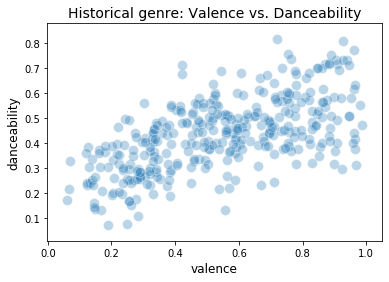

In [352]:
plt.scatter(y = DEP_VAR, x = INDEP_VAR_1, data = ECHO_GENRE, s = 100, alpha = 0.3, edgecolor = 'white')
plt.title(GENRE+' genre: Valence vs. Danceability', fontsize = 14)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)

### Attributes
To build a Simple Linear Regression (SLR) model, we must have an independent variable and a dependent variable. For our SLR model, we are going to take Valence as the independent variable and Danceability as the dependent variable.

In [353]:
# independent variable
X_var = ECHO_GENRE[[INDEP_VAR_1]]

#dependent variable
y_var = ECHO_GENRE[[DEP_VAR]]

In [354]:
# split data in development and internal test
X, X_test, y, y_test = train_test_split(X_var, y_var, test_size=0.30 ,random_state=0)

### SLR model with Statsmodels
In this case we build a simple linear regression model which use statsmodel

In [355]:
# Ordinary Least Square
slr_model = sm.OLS(y_var,X_var)
slr_reg = slr_model.fit()

In [356]:
print( cl( slr_reg.summary(),attrs = ['bold']) )

                                 OLS Regression Results                                
Dep. Variable:           danceability   R-squared (uncentered):                   0.895
Model:                            OLS   Adj. R-squared (uncentered):              0.895
Method:                 Least Squares   F-statistic:                              2978.
Date:                Sun, 11 Apr 2021   Prob (F-statistic):                   1.17e-172
Time:                        20:53:34   Log-Likelihood:                          172.73
No. Observations:                 349   AIC:                                     -343.5
Df Residuals:                     348   BIC:                                     -339.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### SLR model with Scikit-learn

In [357]:
#Function to get cross validation score R2
def get_cv_scores(model,X_train,y_train):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=3,
                             scoring='r2')
    
    print('CV Mean (R2): ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

In [358]:
# build the model
slr = LinearRegression()
slr.fit(X,y)
y_pred = slr.predict(X_test)

In [359]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(slr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.6006648542883892
STD:  0.0262702004242908


***Scores (no cv) on Test Data***
R2: 0.511
MSE: 0.011
MAE: 0.087


In [360]:
# Compute hypotesis weight and bias

# Y = wX+B where X=valence and Y=danceability
slr_slope = slr.coef_ # weight: w
slr_intercept = slr.intercept_ # bias B
print('Coefficients: \n', slr_slope)
print('Intercept: \n', slr_intercept)

Coefficients: 
 [[0.30973969]]
Intercept: 
 [0.25950079]


Text(0.5, 0, 'valence')

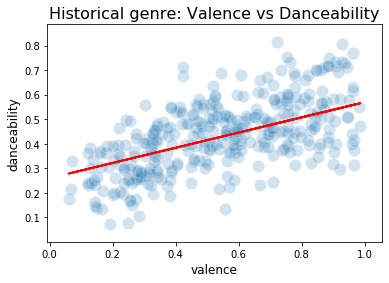

In [361]:
# plot the regression function
sns.scatterplot(x = INDEP_VAR_1, y = DEP_VAR, data = ECHO_GENRE , s = 150, alpha = 0.2, edgecolor = 'white')
plt.plot(ECHO_GENRE[INDEP_VAR_1], slr_slope*ECHO_GENRE[[INDEP_VAR_1]] + slr_intercept, color = 'r', linewidth = 2)
plt.title(GENRE+' genre: Valence vs Danceability', fontsize = 16)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)

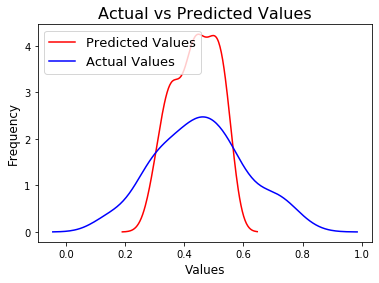

In [362]:
# I valori compresi tra 0.3 e 0.55 vengono predetti più volte di quanto realmente appaiono nella distribuzione.

# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

###  Lasso Simple Linear Regression (L1 Regularization) 

In [363]:
alpha = [random.uniform(1e-6,1) for x in range(10000)]
param_grid = dict(alpha=alpha)

In [364]:
lasso_slr = Lasso()
grid = RandomizedSearchCV(estimator=lasso_slr, param_distributions=param_grid, n_iter=500, cv = 3, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1492 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   11.6s finished


In [365]:
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.2454755793736865
Best Params:  {'alpha': 0.0008878366467861964}


#### Retrain the lasso regression with optimal value of alpha

In [366]:
lasso_slr = Lasso(alpha=0.0006145946430157204)
lasso_slr.fit(X,y)
y_pred = lasso_slr.predict(X_test)

In [367]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(lasso_slr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.6007669821925768
STD:  0.02850556502810501


***Scores (no cv) on Test Data***
R2: 0.500
MSE: 0.011
MAE: 0.088


In [368]:
lasso_slr_slope = lasso_slr.coef_ 
lasso_slr_intercept = lasso_slr.intercept_ 
print('Coefficients: \n', lasso_slr.coef_)
print('Intercept: \n', lasso_slr.intercept_)

Coefficients: 
 [0.29890132]
Intercept: 
 [0.26523314]


Text(0.5, 0, 'valence')

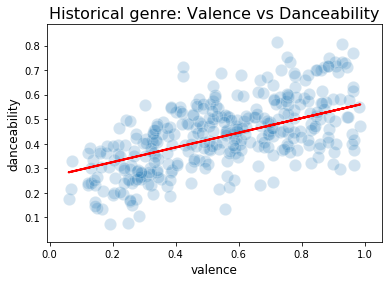

In [369]:
# plot the regression function
sns.scatterplot(x = INDEP_VAR_1, y = DEP_VAR, data = ECHO_GENRE, s = 150, alpha = 0.2, edgecolor = 'white')
plt.plot(ECHO_GENRE[INDEP_VAR_1], lasso_slr_slope*ECHO_GENRE[[INDEP_VAR_1]] + lasso_slr_intercept, color = 'r', linewidth = 2)
plt.title(GENRE+' genre: Valence vs Danceability', fontsize = 16)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)


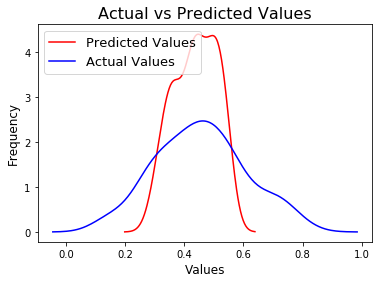

In [370]:
# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

### Ridge Simple Linear Regression (L2 Regularization)

In [151]:
# find optimal alpha with grid search
alpha = [random.uniform(1e-6,1) for x in range(100000)]
param_grid = dict(alpha=alpha)

In [152]:
ridge_slr = Ridge()
grid = RandomizedSearchCV(estimator=ridge_slr, param_distributions=param_grid, n_iter=500, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   12.3s finished


In [153]:
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.24287669314515375
Best Params:  {'alpha': 0.9994553811685056}


#### Retrain ridge regression with optimal value of alpha

In [154]:
ridge_slr = Ridge(alpha=0.9994553811685056)
ridge_slr.fit(X,y)
y_pred = ridge_slr.predict(X_test)

In [155]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(ridge_slr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.5792060928052373
STD:  0.041549641723868797


***Scores (no cv) on Test Data***
R2: 0.489
MSE: 0.012
MAE: 0.088


In [156]:
ridge_slr_slope = ridge_slr.coef_ 
ridge_slr_intercept = ridge_slr.intercept_
print('Coefficients: \n', ridge_slr.coef_)
print('Intercept: \n', ridge_slr.intercept_)

Coefficients: 
 [[0.2888729]]
Intercept: 
 [0.27053712]


Text(0.5, 0, 'valence')

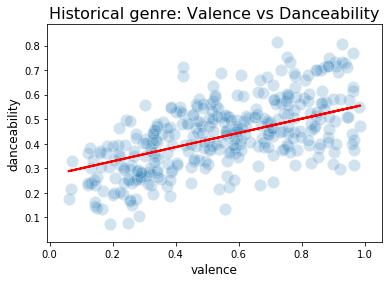

In [157]:
# plot the regression function
sns.scatterplot(x = INDEP_VAR_1, y = DEP_VAR, data = ECHO_GENRE, s = 150, alpha = 0.2, edgecolor = 'white')
plt.plot(ECHO_GENRE[INDEP_VAR_1], ridge_slr_slope*ECHO_GENRE[[INDEP_VAR_1]] + ridge_slr_intercept, color = 'r', linewidth = 2)
plt.title(GENRE+' genre: Valence vs Danceability', fontsize = 16)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)


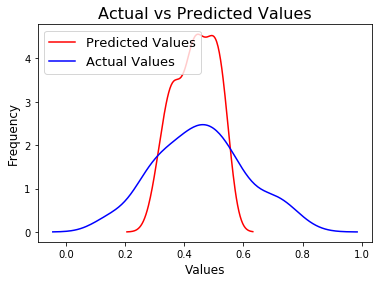

In [158]:
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

# Multivariate Linear Regression: MLR
- **DEPENDENT VARIABLE** = DANCEABILITY
- **INDEPENDENT VARIABLE** = VALENCE, ENERGY, ACOUSTICNESS

In [371]:
# independent variables
X_var = ECHO_GENRE[[INDEP_VAR_1,INDEP_VAR_2,INDEP_VAR_3]]    #acousticness, energy, valence 

#dependent variable
y_var = ECHO_GENRE[[DEP_VAR]] #danceability

In [372]:
# split data in development and internal test
X, X_test, y, y_test = train_test_split(X_var, y_var, test_size=0.30 ,random_state=0)

### E.2) MLR simple model

In [373]:
# build the model (same as before)
mlr = LinearRegression()
mlr.fit(X,y)
y_pred = mlr.predict(X_test)

In [374]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(mlr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.5914501845455984
STD:  0.05386403824869289


***Scores (no cv) on Test Data***
R2: 0.509
MSE: 0.011
MAE: 0.087


In [376]:
mlr_slope = mlr.coef_ # weight: w
mlr_intercept = mlr.intercept_ # bias B
print('Coefficients: \n', mlr_slope)
print('Intercept: \n', mlr_intercept)

Coefficients: 
 [[ 0.31853349 -0.0521483   0.13026902]]
Intercept: 
 [0.2462008]


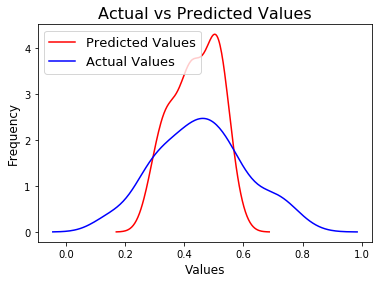

In [377]:
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

### E.3) Lasso MLR model: (L1 Regularization)


In [167]:
alpha = [random.uniform(1e-6,1) for x in range(100000)]
param_grid = dict(alpha=alpha)

In [168]:
lasso_mlr = Lasso()
grid = RandomizedSearchCV(estimator=lasso_mlr, param_distributions=param_grid, n_iter=500, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   12.2s finished


In [169]:
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.2587406613261447
Best Params:  {'alpha': 0.0006984374177029984}


#### Retrain lasso MLR with optimal value of alpha

In [378]:
lasso_mlr = Lasso(alpha=0.0006984374177029984)
lasso_mlr.fit(X,y)
y_pred = lasso_mlr.predict(X_test)

In [379]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(lasso_mlr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.5892811323617688
STD:  0.0375456990813167


***Scores (no cv) on Test Data***
R2: 0.496
MSE: 0.011
MAE: 0.088


In [380]:
lasso_mlr_slope = lasso_mlr.coef_ # weight: w
lasso_mlr_intercept = lasso_mlr.intercept_ # bias B
print('Coefficients: \n', lasso_mlr_slope)
print('Intercept: \n', lasso_mlr_intercept)

Coefficients: 
 [ 0.29438168 -0.          0.10362199]
Intercept: 
 [0.25362256]


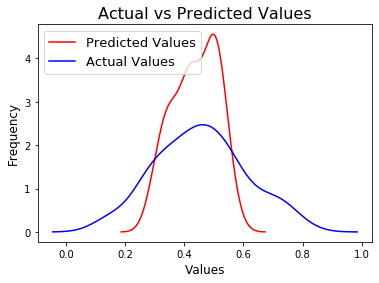

In [381]:
# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

### E.4) Ridge MLR model: (L2 Regularization)


In [174]:
alpha = [random.uniform(1e-6,1) for x in range(100000)]
param_grid = dict(alpha=alpha)

In [175]:
ridge_mlr = Ridge()
grid = RandomizedSearchCV(estimator=ridge_mlr, param_distributions=param_grid, n_iter=500, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   11.3s finished


In [176]:
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.260426909406217
Best Params:  {'alpha': 0.9950484600481623}


#### Retrain ridge MLR with optimal value of alpha

In [382]:
ridge_mlr = Ridge(alpha=0.9950484600481623)
ridge_mlr.fit(X,y)
y_pred = ridge_mlr.predict(X_test)

In [383]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(ridge_mlr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.5704157472072725
STD:  0.04377774706349055


***Scores (no cv) on Test Data***
R2: 0.487
MSE: 0.012
MAE: 0.089


In [384]:
ridge_mlr_slope = ridge_mlr.coef_ # weight: w
ridge_mlr_intercept = ridge_mlr.intercept_ # bias B
print('Coefficients: \n', ridge_mlr_slope)
print('Intercept: \n', ridge_mlr_intercept)

Coefficients: 
 [[ 0.28854518 -0.01181835  0.1125352 ]]
Intercept: 
 [0.25753402]


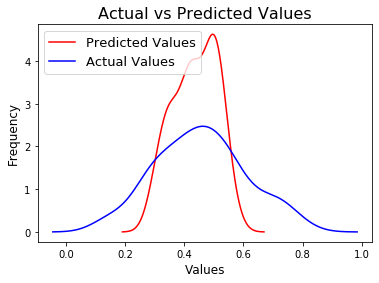

In [385]:
# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)